# [Exploration 12] GAN (Generative Adversarial Network)

작업환경 구성

`$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples`   
`$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints`   
`$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history`

# STEP 1. 데이터셋 구성하기

데이터 불러오기

In [1]:
import os
import glob
import time

import PIL
import imageio

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

데이터 정규화

In [3]:
train_x = (train_x - 127.5) / 127.5

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


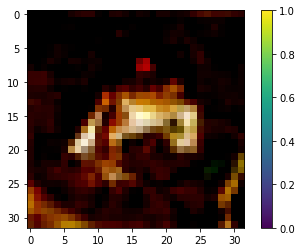

In [6]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

train_y 데이터를 가지고 오지 않아서 이게 뭔지 알수가 없다..   
(왠지 무섭다)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

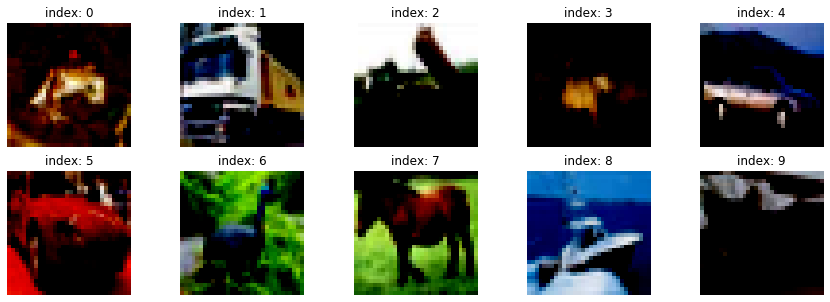

In [7]:
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

10개 확인해보기

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# STEP 2. 생성자 모델 구현하기

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(2, 2), strides=(2, 2), padding='valid', use_bias=False, \
                                     activation='tanh'))

    return model

generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       294912    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)      

keras sequential 모델로 레이어를 구성한다. 총 4층의 레이어가 만들어지는데, 마지막 단계에서 입력이미지와 같은 형상인 32x32x3 의 형태가 만들어지도록 한다.

In [12]:
noise = tf.random.normal([1, 100])

모델이 잘 만들어졌다면 랜덤벡터를 입력하여 이미지를 확인해본다.

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

TensorShape([1, 32, 32, 3]) 의 앞 1은 batch_size가 1이라는 뜻이다.

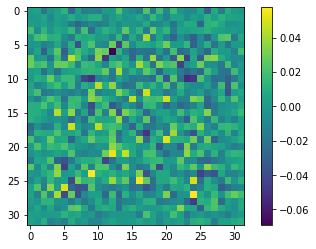

In [14]:
plt.imshow(generated_image[0, :, :,0])
plt.colorbar()
plt.show()

다양한 색이 섞인 32x32의 노이즈 이미지가 생성되었다. 프로젝트를 진행하면서 이 이미지가 어떤식으로 변해가는지 지켜보자.

# STEP 3. 판별자 모델 구현하기

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

판별자 모델은 생성자에서 랜덤으로 생성된 이미지가 진짜인지 가짜인지를 구분하는 역할을 한다.   
입력으로 32x32 이미지 사이를 받고, 출력값으로는 진짜 or 가짜를 판별하는 1차원의 값이 된다.

랜덤한 노이즈를 넣어 생성한 이미지인 `generated_image`를 넣어 결과를 확인해본다.

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00560312]], dtype=float32)>

1, 1의 shape이 보이고, ndarray형태가 보인다.

# STEP 4. 손실함수와 최적화 함수 구현하기

이번 프로젝트에서 가장 어려웠던 부분이 손실함수, 최적화함수를 구현하는 부분이었다.   
하나하나씩 차근차근 풀어보겠다.

## 1. 손실함수

먼저 손실함수로는 **교차 엔트로피(Cross Entropy)**를 사용한다. 교차 엔트로피는 분류 문제에서 **MSE**대신 많이 사용된다.   
그중에서도 우리는 판별자를 통해 진짜인지 가짜인지를 판별하는  **이항 교차 엔트로피(Binary Cross Entropy)**를 사용한다. 

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

`cross_entropy`함수를 케라스를 통해 불러온다. (`from_logits`값은 **True**로 주어야 함수 내부에서 **sigmoid**함수를 사용해 0 ~ 1 사이의 값으로 정규화 시켜줄 수 있다.

다음으로는 `tf.ones.like()`와 `tf.zeros_like()`를 활용해서 **fake_output (fake image를 판별한 값)**과 real_output (real image를 판별한 값)**을 비교하도록 한다.

### 1 - (1) 생성자 손실함수 (generator_loss)

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

생성자 손실함수는 가짜 이미지의 판별값인 `fake_output`이 1이 되어야 하는 목표를 가지고 있다.   
그러므로 `tf.ones_like`를 사용하여 fake_output과의 교차 엔트로피가 낮아질 수 있도록 한다.

### 1 - (2) 판별자 손실함수 (discriminator_loss)

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

판별자 손실함수는 **real_loss**와 **fake_loss**로 구분된다.   
**real_loss**는 판별자를 통해 나온 **real_output** 값이 1이 되어야 하는 손실함수이며,   
**fake_loss**는 판별자를 통해 나온 **fake_output** 값이 0이 되어야 하는 손실함수이다.   
**total_loss**는 이 둘을 더한 값이다.

### 1 - (3) 판별자 정확도 (discriminator accuracy)

판별자(discriminator)는 적절한 가중치 학습을 위해 loss를 구하는 것도 중요하지만, 얼마나 정확히 판별하는지 **accuracy**를 구하는 것도 중요하다.

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 2. 최적화 함수(optimizer)

최적화 함수는 **Adam**을 사용하여 설정해보겠다.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

노드에서는 따로 학습을 진행하기에 각각의 optimizer가 필요하다고 나오는데 잘 이해가 되지는 않는다.

# STEP 5. 훈련과정 상세 기능 구현하기

학습 과정에 들어가기전에 설정을 해둬야할 부분이 있다.   
인풋값으로 랜덤한 노이즈를 입력하게 되는데, 고정된 값을 입력해줘야 진전 과정을 확인할 수 있다.   
그러므로, (16, 100) 형상의 벡터를 고정해둔다.

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

1개의 미니배치의 훈련과정을 처리하는 train_step() 함수를 구현한다.

In [23]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음    

(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함    

(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기    

(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성    

(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후     
real_output, fake_output 출력
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산    

(7) accuracy 계산 : fake_output, real_output으로 discriminator가 정확도를 계산    

(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산   

(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신   

(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

### 생성한 이미지를 시각화하기 위한 함수를 구현

처음 이미지 샘플을 확인했던것과 동일하게 생성된 이미지를 시각화 할 수 있는 함수를 구현한다.

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

다음으로는 로스와 정확도의 히스토리를 딕셔너리에 저장 후 매 epoch마다 그matplotlib으로 그래프화 할수 있도록 함수를 만든다.

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음으로는 체크포인트를 활용하여 버전관리를 할 수 있도록 한다.   

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 6. 학습 과정 진행하기

이전 스텝에서 구현한 함수들을 모두 사용하여 한번에 학습할 수 있는 함수를 구현하도록 한다.

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [28]:
save_every = 1
EPOCHS = 100

에폭값은 100으로 설정하고 학습을 시도해보도록 하겠다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

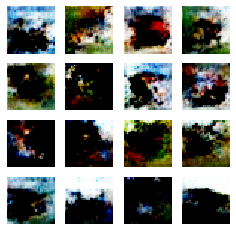

Time for training : 1039 sec


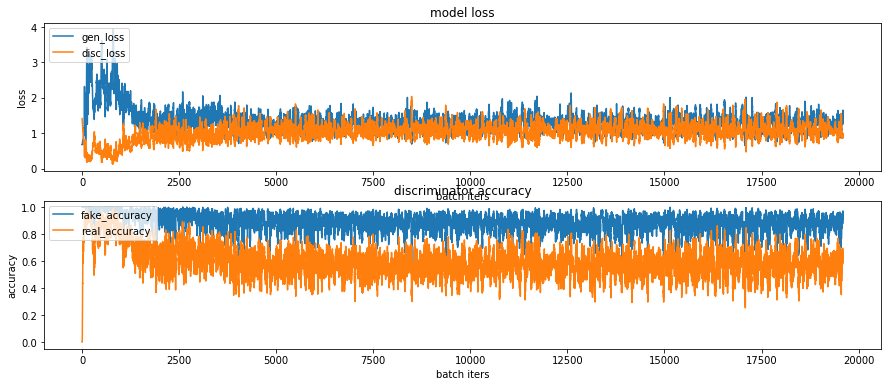

CPU times: user 17min 3s, sys: 54.8 s, total: 17min 57s
Wall time: 17min 20s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

동물 그림과 초록색 자연이 어우러져있는 것같은 이미지가 생성되긴 했다. 에폭값을 더 올리면 결과가 나아질지 궁금하다.   
하지만 다음 스텝에서 결과물을 더 좋게 만드는 방법에 대해 고민하는 스텝이 있으므로 그쪽에서 더 고민해보도록 한다.

file:///home/aiffel-dj58/aiffel/dcgan_newimage/fashion/cifar10.gif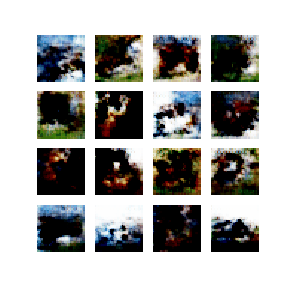

# STEP 7. GAN 훈련 과정 개선하기

마지막 스텝은 GAN으로 생성된 이미지의 결과를 개선해보는 Step이다.   
아래 링크를 참고하여 개선방법에 대해 참고할 수 있다.   


- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)   
- [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)   
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)   
- [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)

 
   
이번 노드가 특별했던 만큼 결과물을 개선해보고 싶지만 제출시간이 다가오는 관계로 생략하기로 하겠다 😓️
    
    



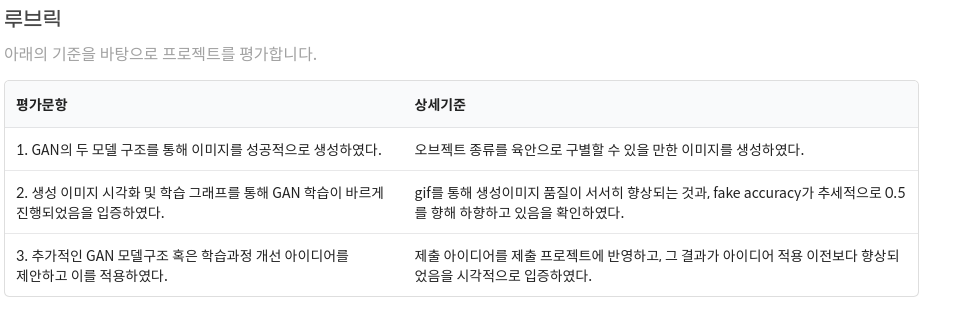

# 회고:  
## 1. **이번 프로젝트에서 어려웠던 점**   
- 생성자와 판별자 손실함수 설정하는 부분   
- 모델 출력 output 크기 맞추는 부분(transpose가 들어가니 더욱 어려웠음)
   
## 2. **프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점**   
무에서 유를 생성하는 방법중 하나로 GAN을 배웠지만, GAN 이외에도 다양한 방법들이 있으며, 창의적으로 활용한다면 무궁무진하게 활용할 수 있음

## 3. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
- GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.   
형체를 알아보기는 어렵지만 생성자와 판별자를 통해 이미지를 생성할 수 있었다.   
- 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.   
- 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.   
생략하였다.

   
### 4. **만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정**   
생각보다 모델 아웃풋을 맞추는 부분이 어려웠다. transpose를 하지 않았을 때는 인풋과 동일한 아웃풋을 출력할 수 있는 공식이 있지만 Transpose의 경우에는 찾아도 나오지 않아 출력값을 떄려맞췄다.
   
### 5. **자기 다짐**   
GAN은 다시한번 꼭 복습하여 좋은 결과물을 내보고싶은 노드중 하나이다. 또 CV 분야 중, 활용할 수 있는 부분이 많을 것이라 생각한다. 주말을 통해 더 복습하고 공부하여 이후에 있을 GAN 노드에서는 꼭 좋은 결과물을 내보이고 싶다.

   